## packages

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
from datetime import datetime, timedelta
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

## Funciones

In [2]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x 

In [3]:
def mov_avg(array, time_values, nsmooth):
    df = pd.DataFrame(np.transpose(array), columns = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25'])
    df.index = time_values
    mask = []
    for i in range(len(time_values)):
        if i%nsmooth == 0:
            mask.append(True)
        else:
            mask.append(False)
    df['blank'] = np.zeros(len(df))
    new_df = df['blank'][mask].to_frame()
    for i in df.columns:
        rolling = df[i].rolling(window=nsmooth, min_periods=1)
        rolling_mean = rolling.mean()
        masked_rolling_mean = rolling_mean[mask]
        new_df[i] = masked_rolling_mean
    new_df.drop('blank', inplace=True, axis=1)
    return new_df

## Importar datos

In [4]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [5]:
adcp_new = adcp.sel(time=slice("2012-02-17","2012-03-08"))

In [6]:
#Importar datos de backscatter
bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
bks_drp1 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp1.npy")
bks_drp2 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp2.npy")
bks_drp3 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp3.npy")
bks_drp4 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp4.npy")
# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

In [7]:
#Datos velocidad vertical
vert = np.load("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//ADCP//vert.npy")
vert2 = np.load("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//ADCP//vert2.npy")

In [8]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
dc1 = DC_1.loc[datetime.date(2012,2,17):datetime.date(2012,3,14)]

In [9]:
y_bin = np.linspace(1.19, 3.59, 25)
n_time = len(adcp.temperature)

# Obtener backscatter

In [5]:
# %script to calculate the acoustic backscatter from an
# %RDI
# % From Laurent from Alex
# %
# % this followes Deines 1999 method.  Needs to be altered re: JTECH 2010
# % paper by G....iaux and van Haren. 
#
# ​Written in Python from Matlab by Dhannai
#
# %R=cfg.ranges/(cos(pi/180*cfg.beam_angle));
R = adcp.config.ranges/(np.cos(np.pi/180*adcp.config.beam_angle))
if (adcp.config.beam_freq==1200):
  print('Using constants for 1200kHz ADCP.')
  taR=2*.48*R;    # for 1200
elif (adcp.config.beam_freq==600): 
  print('Using constants for 600kHz ADCP.')
  taR=2*.153*R;    # for 600

ldbm=10*np.log10(adcp.config.xmit_pulse)
#ldbm=10*log10(cfg.xmit_pulse);
kk_beam1 = adcp.intens.isel(beam=0)
kk_beam2 = adcp.intens.isel(beam=1)
kk_beam3 = adcp.intens.isel(beam=2)
kk_beam4 = adcp.intens.isel(beam=3)
kk=np.mean(adcp.intens,2)
bsk_beam1=0.458*(kk_beam1-40)
bsk_beam2=0.458*(kk_beam2-40)
bsk_beam3=0.458*(kk_beam3-40)
bsk_beam4=0.458*(kk_beam4-40)
bsk=0.458*(kk-40)
Sv_beam1 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam2 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam3 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam4 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
for i in range(adcp.config.n_cells):
    Sv_beam1[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam1[:,i]
    Sv_beam2[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam2[:,i]
    Sv_beam3[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam3[:,i]
    Sv_beam4[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam4[:,i]
    Sv[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk[:,i]


Using constants for 1200kHz ADCP.


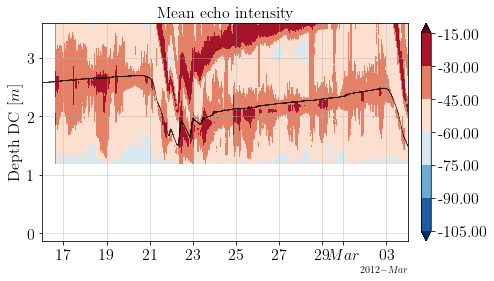

In [8]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         Sv,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.plot(DC_1.index, DC_1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(dtz.date(2012,2,16),dtz.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

# Eliminar valores

In [10]:
z = DC_1["Depth"]
Sv_new = Sv.copy()
for i in range(n_time-19):
    cont = 0
    for j in y_bin:
        if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
            i = i+1
        if z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] > j:
            cont+=1
        elif z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] <= j:
            break
    Sv_new[cont:, i] = np.nan
        

In [11]:
n_time = len(Sv_new[0,:])

In [16]:
z = DC_1["Depth"]

Sv_bks = Sv.copy()
Sv_b1 = Sv_beam1.copy()
Sv_b2 = Sv_beam2.copy()
Sv_b3 = Sv_beam3.copy()
Sv_b4 = Sv_beam4.copy()

for i in range(n_time-19):
    if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
        i = i+1
    max_height = z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0]
    m = np.where(y_bin>=max_height)
    Sv_bks[m,i] = np.nan
    Sv_b1[m,i] = np.nan
    Sv_b2[m,i] = np.nan
    Sv_b3[m,i] = np.nan
    Sv_b4[m,i] = np.nan

In [13]:
Sv_new

array([[-106.08742174, -106.20192174, -106.54556807, ..., -106.53942632,
        -106.76886473, -106.53971859],
       [-106.04542849, -105.81642849, -105.93107482, ..., -105.92493307,
        -106.26887148, -105.92522534],
       [-106.02163796, -105.67813796, -105.67828429, ..., -105.78664255,
        -105.67258096, -105.67243481],
       ...,
       [          nan,           nan,           nan, ...,  -99.01235588,
         -98.55479429,  -98.66914815],
       [          nan,           nan,           nan, ...,  -98.45368648,
         -97.99612489,  -98.22497874],
       [          nan,           nan,           nan, ...,  -98.59497509,
         -98.0229135 ,  -97.90826736]])

In [18]:
np.save("data/bks_drp.npy", Sv_bks) 
np.save("data/bks_drp1.npy", Sv_b1) 
np.save("data/bks_drp2.npy", Sv_b2) 
np.save("data/bks_drp3.npy", Sv_b3) 
np.save("data/bks_drp4.npy", Sv_b4) 

In [7]:
max_height = DC_1["Depth"]
len(max_height)

556306

In [10]:
Sv

array([[-106.08742174, -106.20192174, -106.54556807, ...,  -46.85368976,
         -46.51003682,  -46.6243839 ],
       [-106.04542849, -105.81642849, -105.93107482, ...,  -40.62869651,
         -40.39954358,  -40.97189065],
       [-106.02163796, -105.67813796, -105.67828429, ...,  -38.88740598,
         -38.31475305,  -39.68860012],
       ...,
       [ -98.7893513 ,  -98.3313513 ,  -98.78949763, ...,  -43.10511932,
         -45.28046639,  -44.47881346],
       [ -98.34518189,  -98.11618189,  -98.34532822, ...,  -56.17194991,
         -55.02679698,  -52.16414405],
       [ -98.02847051,  -97.68497051,  -97.68511684, ...,  -62.95423853,
         -61.9235856 ,  -60.32043267]])

In [ ]:
max_height = DC_1["Depth"]
Sv_bks = Sv.copy()
Sv_b1 = Sv_beam1.copy()
Sv_b2 = Sv_beam2.copy()
Sv_b3 = Sv_beam3.copy()
Sv_b4 = Sv_beam4.copy()

for i in range(len(max_height)):
    m = np.where(y_bin>=max_height[i])

    Sv_bks[m,i] = np.nan
    Sv_b1[m,i] = np.nan
    Sv_b2[m,i] = np.nan
    Sv_b3[m,i] = np.nan
    Sv_b4[m,i] = np.nan
    


In [24]:
z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0]

2.5920087498316007

In [26]:
z = DC_1["Depth"]
Sv_new = Sv.copy()
for i in range(100):
    cont = 0
    print("i")
    print(i)
    for j in y_bin:
        if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
            i = i+1
            print(len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values))
        if z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] > j:
            cont+=1
            print(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0])
        elif z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] <= j:
            print("z")
            print(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0])
            print("j")
            print(j)
            break
    Sv_new[cont:, i] = np.nan
        


i
0
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
z
2.5930192996288532
j
2.61
i
1
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
z
2.5920821186322605
j
2.61
i
2
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2

# Eliminar valores velocidad vertical

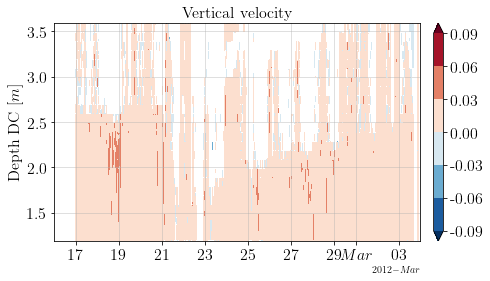

In [17]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title("Vertical velocity",
          fontsize=16)
contourf_ = ax3.contourf(adcp_new.time, y_bin,
                         vert,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

In [19]:
z = DC_1["Depth"]

# vertical = np.transpose(adcp.vert_vel.sel(time=slice("2012-02-16","2012-03-03")).values)
Vel_vert = vert.copy()

n_time = len(vert[0,:])

for i in range(n_time-19):
    if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
        i = i+1
    max_height = z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0]
    m = np.where(y_bin>=max_height)
    Vel_vert[m,i] = np.nan

In [20]:
np.save("data/Vel_vert.npy", Vel_vert) 

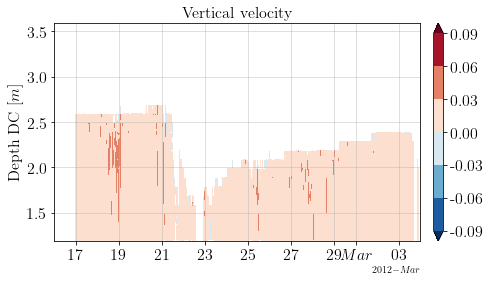

In [21]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 40)
level_boundaries_v = np.linspace(vmin, vmax, 40)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title("Vertical velocity",
          fontsize=16)
contourf_ = ax3.contourf(adcp_new.time, y_bin,
                         Vel_vert,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

In [25]:
df_vert = mov_avg(Vel_vert, adcp_new.time.values, nsmooth=10)

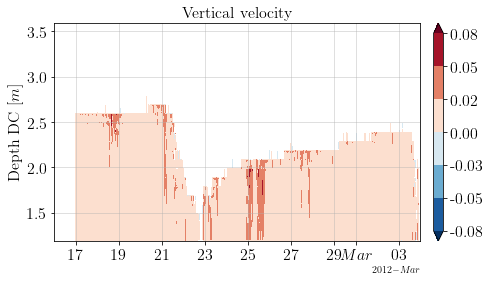

In [31]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 40)
level_boundaries_v = np.linspace(vmin, vmax, 40)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title("Vertical velocity",
          fontsize=16)
contourf_ = ax3.contourf(df_vert.index, y_bin,
                         np.transpose(df_vert.values),
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show()

In [33]:
df_vert.to_csv('data/burst_vert.csv')

In [34]:
df_vert

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_16,bin_17,bin_18,bin_19,bin_20,bin_21,bin_22,bin_23,bin_24,bin_25
2012-02-17 00:00:00,0.000536,0.000349,0.000537,0.001181,0.000608,0.000776,0.001436,0.002488,0.002147,0.001942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-17 00:00:05,0.000738,0.000800,0.000842,0.000565,0.000720,0.000915,0.001807,0.002016,0.002240,0.002342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-17 00:00:10,0.000284,0.000913,0.001484,0.000962,0.000456,0.000953,0.001262,0.001646,0.001640,0.001736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-17 00:00:15,0.000902,0.001423,0.000931,0.000228,-0.000050,-0.000551,-0.000188,0.000740,0.000531,0.001394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-17 00:00:20,0.000407,0.001044,0.000896,0.000831,0.000172,0.000182,0.000697,0.000607,0.000394,0.000478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-03-08 23:54:35,0.001595,0.003203,0.002154,0.003726,0.014604,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-08 23:54:40,0.001261,0.000926,0.000978,0.003161,0.024321,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-08 23:54:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-08 23:54:50,0.002165,0.000938,0.000884,0.004745,0.021881,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Gráficos

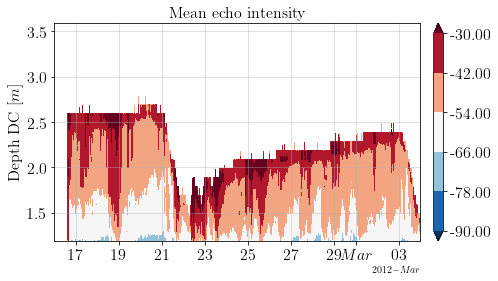

In [8]:
#Ajustar limites colorbar
umin = -90
umax = -30
vmin = -90
vmax = -30
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

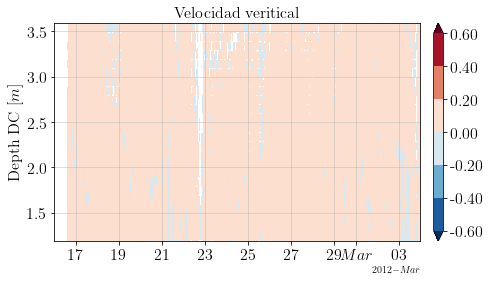

In [15]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title(r"Velocidad veritical",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         Vel_vert,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

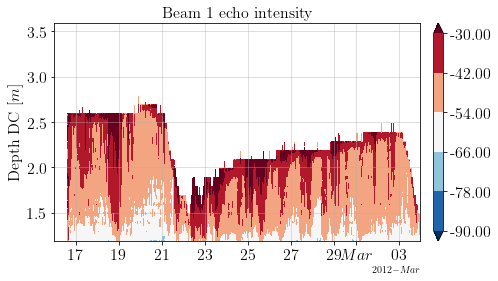

In [9]:
#Ajustar limites colorbar
umin = -90
umax = -30
vmin = -90
vmax = -30
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 1 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp1,
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

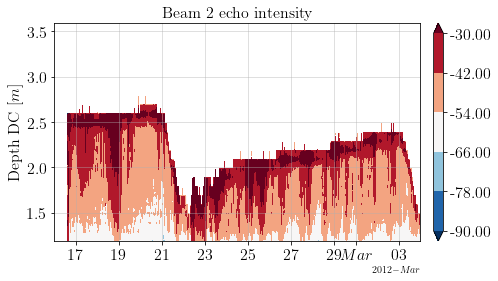

In [10]:
#Ajustar limites colorbar
umin = -90
umax = -30
vmin = -90
vmax = -30
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 2 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp2,
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

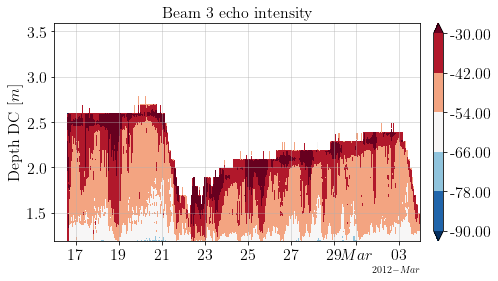

In [11]:
#Ajustar limites colorbar
umin = -90
umax = -30
vmin = -90
vmax = -30
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 3 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp3,
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

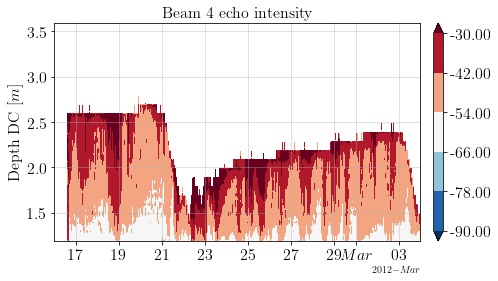

In [12]:
#Ajustar limites colorbar
umin = -90
umax = -30
vmin = -90
vmax = -30
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 4 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp4,
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

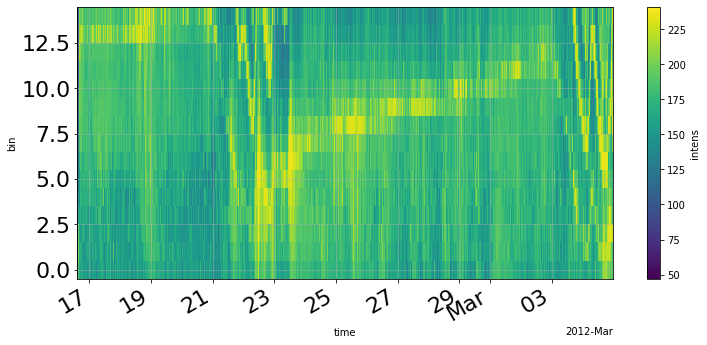

In [3]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 1].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

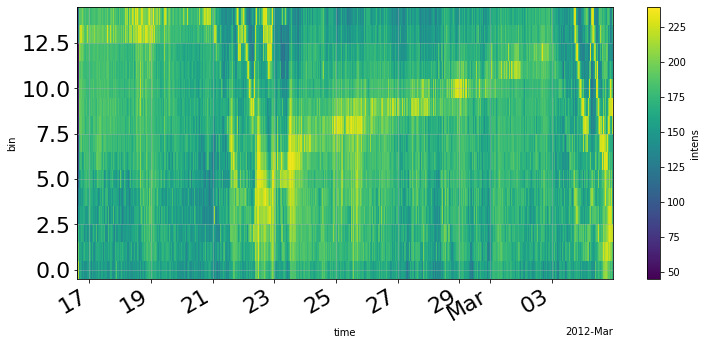

In [4]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 2].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

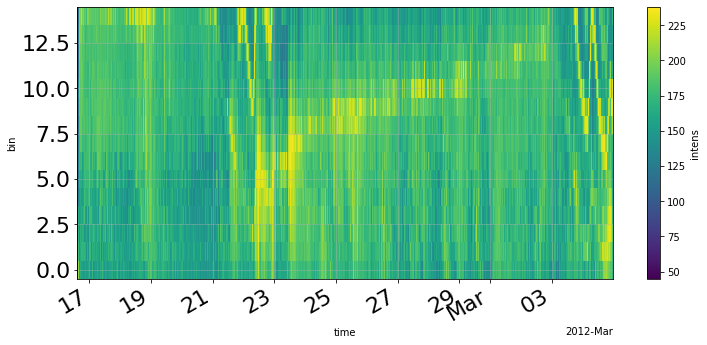

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 3].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

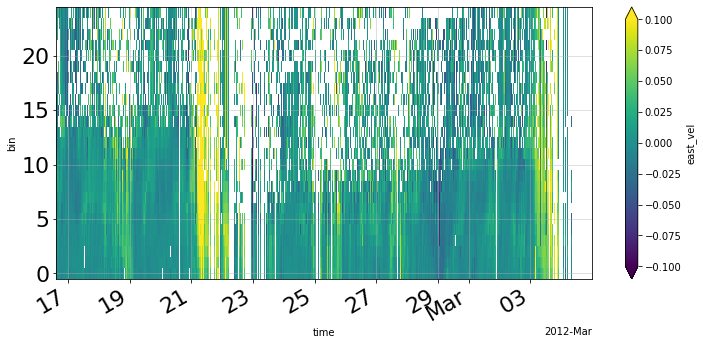

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

contourf_ = feb16.sel(time=slice(None,"2012-03-04")).east_vel.plot(x='time', y='bin', ax=ax, vmin=-0.1, vmax=0.1)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)


# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Buscar picnoclina

In [17]:
n, m = bks_drp1.shape

In [16]:
y_bin

array([1.19, 1.29, 1.39, 1.49, 1.59, 1.69, 1.79, 1.89, 1.99, 2.09, 2.19,
       2.29, 2.39, 2.49, 2.59, 2.69, 2.79, 2.89, 2.99, 3.09, 3.19, 3.29,
       3.39, 3.49, 3.59])

In [26]:
dz = y_bin[:n-1] - y_bin[1:]
diff = np.zeros((n-1, m))
for i in range(m):
    dbks = bks_drp1[:n-1, i] - bks_drp1[1:, i]
    D = dbks/dz
    diff[:, i] = D


    

In [32]:
diff

array([[  -9.88506751,   -0.72506751,   -5.30506751, ...,   67.97493249,
          67.97493249,   63.39493249],
       [  -2.05209474,   -6.63209474,    2.52790526, ...,   11.68790526,
          11.68790526,    2.52790526],
       [  -1.16720302,   -1.16720302,   -5.74720302, ...,    7.99279698,
           7.99279698,    7.99279698],
       ...,
       [          nan,           nan,           nan, ...,    4.58189989,
         -73.27810011, -206.09810011],
       [          nan,           nan,           nan, ..., -183.33830594,
         -73.41830594, -114.63830594],
       [          nan,           nan,           nan, ..., -151.40788615,
        -123.92788615,  -41.48788615]])

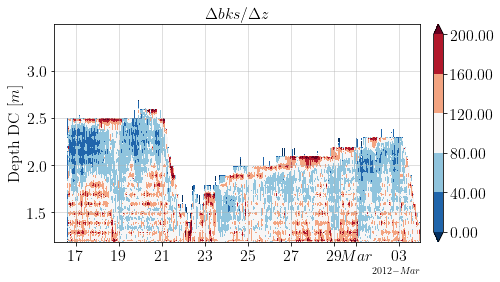

In [36]:
#Ajustar limites colorbar
umin = 0
umax = 200
vmin = 0
vmax = 200
level_boundaries_u = np.linspace(umin, umax, 6)
level_boundaries_v = np.linspace(vmin, vmax, 6)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title(r"$\Delta bks/ \Delta z$",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin[:-1],
                         diff,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

# Promediar velocidad vertical por bursts

In [13]:
vert_burst = pd.read_csv('burst_vert.csv')
vert_burst.index = pd.to_datetime(vert_burst['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
vert_burst = vert_burst.drop(['Unnamed: 0'], axis=1)

In [27]:
df = mov_avg(np.transpose(vert_burst.values), vert_burst.index, nsmooth=120)

In [31]:
bvert = vert_burst.loc[datetime(2012,2,16,0,0,0):datetime(2012,2,17,1,0,0 )]
dfvert = df.loc[datetime(2012,2,16,0,0,0):datetime(2012,2,17,1,0,0 )]

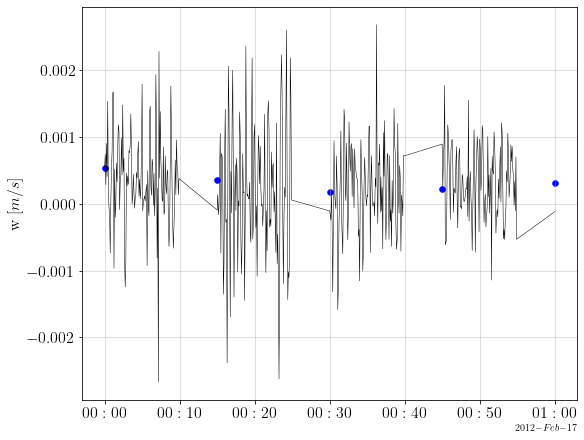

In [35]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax4) = plt.subplots(nrows=1, figsize=(8, 6), constrained_layout=True, sharex=True)

# Velocidad vertical

ax4.plot(bvert.index, bvert['bin_1'], c='k', lw=0.5)
ax4.scatter(dfvert.index, dfvert['bin_1'], c='b', lw=0.5)
ax4.set_ylabel(r"w "
          r"$\displaystyle[m/s]$",
          fontsize=16)

ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

In [36]:
df.to_csv('data/burst_vert.csv')